# Easy

## 5E1

**A:** (2) and (4)

## 5E2

$$ \mu_{i} = \alpha + \beta_{L}L_{i} + \beta_{P}P_{i}$$

## 5E3

$$ \mu_{i} = \alpha + \beta_{F}F_{i} + \beta_{L}L_{i}$$

The important thing here to note is that Funding (F) and size of Lab (L) are correlated with each other. If their correlation is negative then they both affect the result positively. If their relation is positive, they should be on the opposite side of zero. The question actually leaves open which is the case here...

## 5E4

**A:** (1), (3), (4) and (5) are inferentially equivalent. (2) stands out because of the redundant parameter a.

# Medium

## 5M1

In [114]:
from scipy.stats import norm
import pandas as pd
import seaborn as sns
%matplotlib inline

n = 100
x_real = norm(0,1).rvs(100)
x_spurr = norm.rvs(x_real)
y = norm.rvs(x_real)
d = pd.DataFrame({
   "y": y,
    "x_real": x_real,
    "x_spurr": x_spurr
    
})

In [115]:
from numpy import corrcoef

corrcoef([x_real, x_spurr, y])

array([[1.        , 0.74923711, 0.78811377],
       [0.74923711, 1.        , 0.66742721],
       [0.78811377, 0.66742721, 1.        ]])

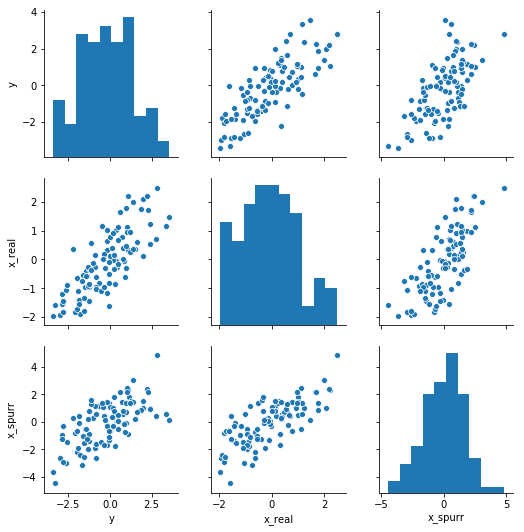

In [116]:
sns.pairplot(d);

In [117]:
import pymc3 as pm

with pm.Model() as m_5m1:
    sigma = pm.HalfNormal('sigma', sd=1)
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_r = pm.Normal('beta_r', mu=0, sd=5)
    beta_s = pm.Normal('beta_s', mu=0, sd=5)
    mu = alpha + beta_r*d.x_real + beta_s*d.x_spurr
    y = pm.Normal('y', mu, sigma, observed=d.y)
    
    trace_5m1 = pm.sample()

pm.summary(trace_5m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_s, beta_r, alpha, sigma]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2934.50draws/s]
The acceptance probability does not match the target. It is 0.8878323389543832, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-0.101239,0.093674,0.002212,-0.273387,0.084715,1854.377233,1.000978
beta_r,0.946184,0.139140,0.003723,0.658867,1.215357,1230.007414,1.000966
beta_s,0.171286,0.094663,0.002569,-0.015128,0.358797,1145.436059,1.001042
sigma,0.957709,0.066521,0.001501,0.837781,1.090249,1735.474217,0.999239


In [118]:
# How does it look if we model bivariate  relationships?
# For simplicity with glms

from sklearn.linear_model import LinearRegression

glm_real = LinearRegression().fit(d["x_real"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(-0.09146804930928011, array([1.13323232]))

In [119]:
glm_real = LinearRegression().fit(d["x_spurr"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(-0.15837970330604295, array([0.65608675]))

In [120]:
glm_real = LinearRegression().fit(d.drop("y", axis=1), d['y'])
glm_real.intercept_, glm_real.coef_

(-0.10023962539649364, array([0.94425608, 0.17243096]))

**A:** As we can see the spurious correlation is discovered when using both variables as predictors. X_real is discovered as the better predictor and only very little of the remaining variance is explaning by x_spurr after controling for x_real.

## 5M2

In [212]:
from numpy import sqrt

n = 100
rho = -0.7
x_1 = norm(0,1).rvs(100)
x_2 = norm.rvs(x_1*rho, sqrt(1-rho**2))
mu_y = x_1 + x_2
y = norm.rvs(mu_y)

d = pd.DataFrame({
   "y": y,
    "x_1": x_1,
    "x_2": x_2
    
})

In [213]:
corrcoef([x_1, x_2, y])

array([[ 1.        , -0.73711911,  0.35825047],
       [-0.73711911,  1.        ,  0.1557445 ],
       [ 0.35825047,  0.1557445 ,  1.        ]])

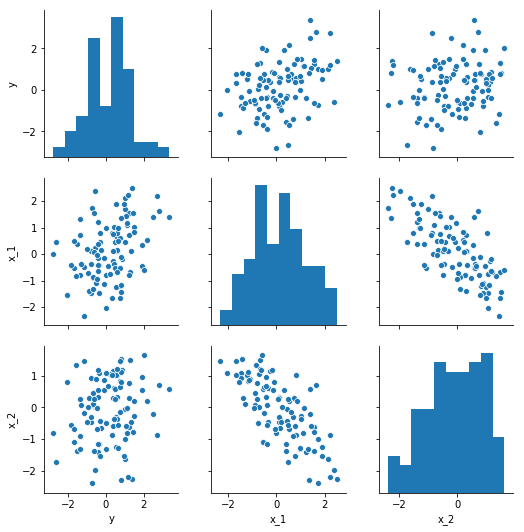

In [214]:
sns.pairplot(d);

In [215]:
with pm.Model() as m_5m2:
    alpha = pm.Normal("alpha", mu=0, sd=1)
    beta_1 = pm.Normal("beta_1", mu=0, sd=1)
    beta_2 = pm.Normal("beta_2", mu=0, sd=1)
    mu = alpha + beta_1 * d.x_1 + beta_2 * d.x_2
    sigma = pm.HalfNormal("sigma", sd=1)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d.y)
    
    trace_5m2 = pm.sample()
    
pm.summary(trace_5m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_2, beta_1, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3075.62draws/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.126533,0.081388,0.002022,-0.028891,0.281504,1500.252612,1.000371
beta_1,1.077147,0.113075,0.002686,0.856467,1.301323,1633.736474,0.999199
beta_2,1.050314,0.123527,0.003049,0.822526,1.295280,1676.563015,0.999216
sigma,0.829710,0.059011,0.001340,0.712232,0.942690,1725.416777,0.999227


In [216]:
from sklearn.linear_model import LinearRegression

glm_real = LinearRegression().fit(d["x_1"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(0.12233645080141826, array([0.3839849]))

In [217]:
glm_real = LinearRegression().fit(d["x_2"].values.reshape(-1,1), d['y'])
glm_real.intercept_, glm_real.coef_

(0.1908136186688859, array([0.18339249]))

In [218]:
glm_real = LinearRegression().fit(d.drop("y", axis=1), d['y'])
glm_real.intercept_, glm_real.coef_

(0.12344751825351519, array([1.11032035, 1.08253269]))

**A:** As we can see x_1 and x_2 are negatively correlated. But together they both have a positive influence on y.

## 5M3

**Q:** It is sometimes observed that the best predictor of fire risk is the presence of firefighters—
States and localities with many firefighters also have more fires. Presumably firefighters do not cause
fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the
same reversal of causal inference in the context of the divorce and marriage data. How might a high
divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using
multiple regression?

#### Notes
* An intuitive explanation would be that people who like to marry but get divorced get a chance to marry more often. Generally they should be older when they get around to their second, third, etc. marriages. So maybe this tendency can be recovered by using medianAgeMarriage somehow.
* But: Is Marriage even counted like that...? I personally would interpret MarriageRate as the percentage of population that lives in wedlock as of the moment of data collection. In this case a causal influence of DivorceRate on MarriageRate would be expected to be slightly negative.

In [1]:
import pandas as pd

df = pd.read_csv("../datasets/WaffleDivorce.csv", sep=";")

In [2]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


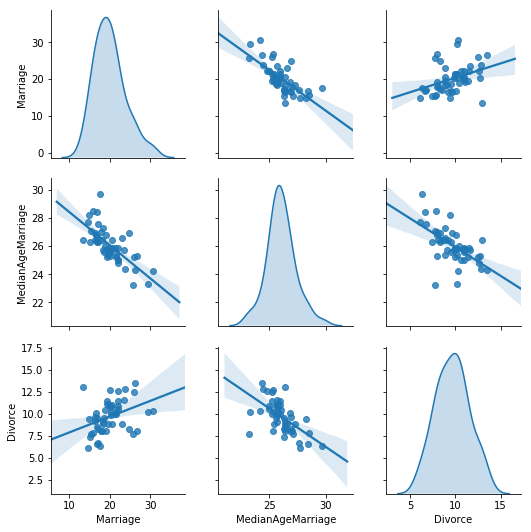

In [3]:
import seaborn as sns
%matplotlib inline

sns.pairplot(df, vars=['Marriage', 'MedianAgeMarriage', 'Divorce'], kind='reg', diag_kind='kde');

In [4]:
from sklearn.preprocessing import scale

df["Divorce_s"] = scale(df.Divorce)
df["MedianAgeMarriage_s"] = scale(df.MedianAgeMarriage)
df["Marriage_s"] = scale(df.Marriage)

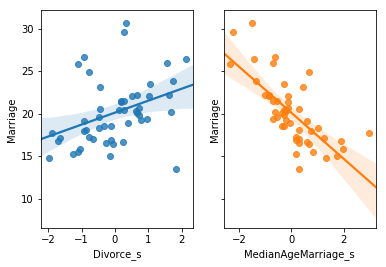

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x="Divorce_s", y="Marriage", data=df, ax=ax1)
sns.regplot(x="MedianAgeMarriage_s", y="Marriage", data=df, ax=ax2)
plt.show()

In [8]:
lm = LinearRegression().fit(df[['Divorce_s']], df['Marriage'])
lm.intercept_, lm.coef_

(20.114000000000004, array([1.40513099]))

In [9]:
lm = LinearRegression().fit(df[['MedianAgeMarriage_s']], df['Marriage'])
lm.intercept_, lm.coef_

(20.114000000000015, array([-2.71112944]))

In [7]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(df[['Divorce_s', "MedianAgeMarriage_s"]], df['Marriage'])
lm.intercept_, lm.coef_

(20.114000000000015, array([-0.33275301, -2.90986258]))

* Divorce Rate alone is positively correlated with MarriageRate
* Median Age of Marriage alone is negatively correlated with MarriageRate
* But: Incorporating both variables gives us a negative coefficient for DivorceRate. What does this mean?
  * Controlling for MedianAge a higher Divorce Rate leads to a slightly lower Marriage Rate. The effect, however, is weak. Mean and sd of the parameter would be interesting.
  * That seems to say the opposite of what was asked in the question: A high divorce rate has a weakly negative effect on marriage rate, if even. So, the answer to the question is: Divorce Rate does not cause Marria Rate after controlling for age.

**Follow Up Question:** Why are we controlling for Age again? What does this mean in natural language?
**A:** "Once we know the MedianAgeOfMarriage for a state there is very little additional predictivce power in knowing the DivorceRate also."

## 5M4

**Q:** In the divorce data, States with high numbers of Mormons (members of The Church of Jesus
Christ of Latter-day Saints, LDS) have much lower divorce rates than the regression models expected.
Find a list of LDS population by State and use those numbers as a predictor variable, predicting di-
vorce rate using marriage rate, median age at marriage, and percent LDS population (possibly stan-
dardized). You may want to consider transformations of the raw percent LDS variable.

In [30]:
import pandas as pd
lds_df = pd.read_csv("../datasets/LdsPopulation.csv", converters={'LDS':lambda x: float(x.strip('%'))})

In [31]:
divorce_df = pd.read_csv("../datasets/WaffleDivorce.csv", sep=';')

In [32]:
df = pd.merge(divorce_df, lds_df[['State', 'LDS']], how='left', left_on='Location', right_on='State')

In [33]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,State,LDS
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,Alabama,0.78
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,Alaska,4.52
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,Arizona,6.03
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,Arkansas,1.05
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,California,1.92


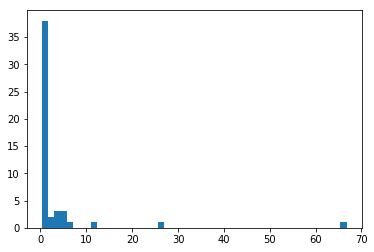

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df.LDS, bins=50);

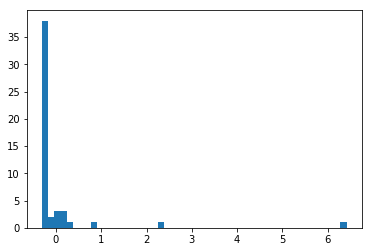

In [38]:
from sklearn.preprocessing import scale
plt.hist(scale(df.LDS), bins=50);

In [39]:
df["LDS_s"] = scale(df.LDS)

In [40]:
from sklearn.preprocessing import scale

df["Divorce_s"] = scale(df.Divorce)
df["MedianAgeMarriage_s"] = scale(df.MedianAgeMarriage)
df["Marriage_s"] = scale(df.Marriage)

In [55]:
import pymc3 as pm

with pm.Model() as m_5m4:
    a = pm.Normal('a', mu=25, sd=15)
    b = pm.Normal('b', mu=0, sd=10, shape=3)
    sigma = pm.HalfNormal('sigma', sd=10)
    mu = pm.Deterministic('mu', a + b[0] * df.MedianAgeMarriage_s + b[1] * df.Marriage_s + b[2] * df.LDS_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed = df.Divorce)
    trace_5m4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1930.95draws/s]


In [56]:
varnames = ['a', 'b', 'sigma']

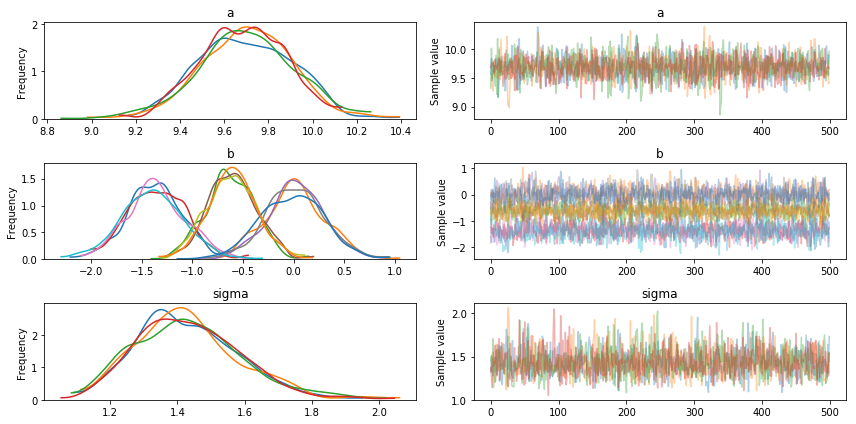

In [57]:
pm.traceplot(trace_5m4, varnames=varnames);

In [60]:
pm.summary(trace_5m4, varnames=varnames).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.693,0.206,0.004,9.299,10.074,2380.379,1.000
b__0,-1.369,0.291,0.007,-1.906,-0.767,1719.030,1.002
b__1,0.007,0.296,0.007,-0.577,0.581,1892.178,1.002
b__2,-0.615,0.242,0.005,-1.073,-0.126,1877.468,1.000
sigma,1.434,0.156,0.004,1.152,1.735,1972.714,0.999


**A:** LDS further explains away the influence of MarriageRate and also diminuishes the influence of MedianAgeMarriage as a predictor. Hence it provides a lot of value as an explanatory variable.

**Follow Up Question:** What about other formats of LDS (raw, as ratio)? 

Generally, the question we want to answer is this: What effect (controlled for all other variables) has a one unit change in the predictor on the predicted variable. Scaling a percentage value as a proportion between 0 and 1 doesn't make much  sense in that regard. But, taking a look at the raw percentage value as preditor is interesting. However, that beta should get a seperate prior in that case.

In [61]:
import pymc3 as pm

with pm.Model() as m_5m4_b:
    a = pm.Normal('a', mu=25, sd=15)
    b = pm.Normal('b', mu=0, sd=10, shape=2)
    b_lds = pm.Normal('b_lds', mu=0, sd=1)
    sigma = pm.HalfNormal('sigma', sd=10)
    mu = pm.Deterministic('mu', a + b[0] * df.MedianAgeMarriage_s + b[1] * df.Marriage_s + b_lds * df.LDS)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed = df.Divorce)
    trace_5m4_b = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_lds, b, a]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1830.21draws/s]


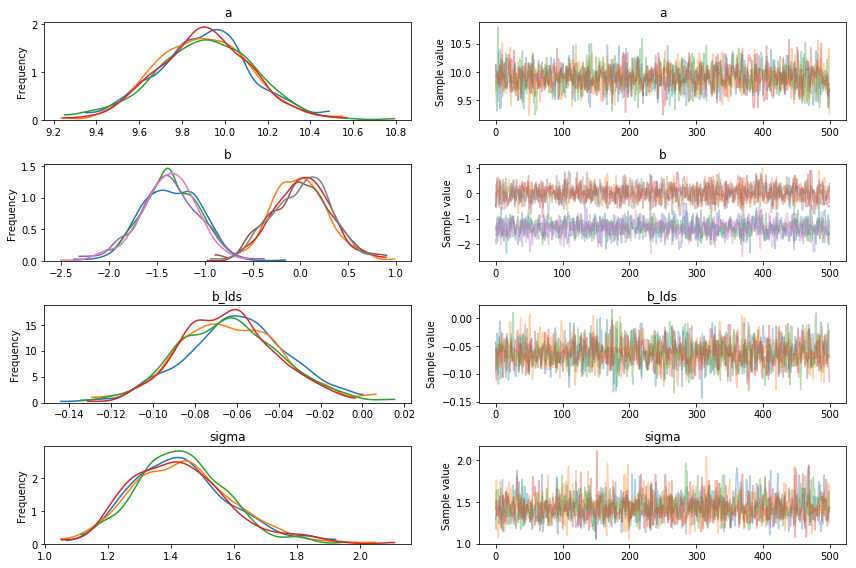

In [63]:
varnames=['a', 'b', 'b_lds', 'sigma']
pm.traceplot(trace_5m4_b, varnames=varnames);

In [64]:
pm.summary(trace_5m4_b, varnames=varnames).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,9.901,0.219,0.005,9.478,10.325,2005.303,0.999
b__0,-1.370,0.302,0.008,-1.944,-0.783,1455.789,1.001
b__1,0.005,0.304,0.007,-0.623,0.566,1541.655,0.999
b_lds,-0.063,0.024,0.001,-0.107,-0.013,2058.887,1.002
sigma,1.434,0.153,0.003,1.145,1.737,2107.730,0.999


Doesn't change much except maybe for the interpretability of the predictor. Which is now saying, how much change in MarriageRate we can expect for one percentage point of LDS-Population.

## 5M5

**Q:** One way to reason through multiple causation hypotheses is to imagine detailed mechanisms
through which predictor variables may influence outcomes. For example, it is sometimes argued that
the price of gasoline (predictor variable) is positively associated with lower obesity rates (outcome
variable). However, there are at least two important mechanisms by which the price of gas could
reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to
less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals.
Can you outline one or more multiple regressions that address these two mechanisms? Assume you
can have any predictor data you need.

**Discussion:** Post-Treatment-Bias seems to be of interest in both cases here. In the first case "Less Driving" and "More Excercise" should not be included as predictor variables. In the second case, "Less Driving", "Less Eating Out", and "Less Consumption of Restaurant Meals" should not be included as predictors. At least according to conventional Wisdom. See Gelman et al. - Data Analysis Using Regression and Multilevel/Hierarchical Models, pp. 188 - 192. The problem here is that the predictive value of the post treatment effect will soak up the effect of treatment. So, if we are interested in the total effect of the treatment variable "Gas Price" we should not control for intermediate / post-treatment-variables.

But still, since the post treatment effect are not caused ONLY by the Gas Prices, they probably carry additional information. Is there a way to include that information into a multiple regression? The question we thus want to answer would be: "What is the direct effect of Gas Prices 'net' [sic Gelman] the effect of Excercise?". That requires us to make further assumptions:

Ostensibly, in case one, we could run a regression with Gas Price as the only predictor and another regression with ExcerciseRate as additional predictor. The rate of change in the coefficient could be seen as proportion of the Gas Price Effect that acts through the intermediate variable ExcerciseRate. E.g. if the GasPrice coefficient is reduced to zero, one will assume that the entire effect of the treament acts through the intermediate. If it is cut in half, the effect of GasPrice net the effect of ExcerciseRate is half the total effect. As Gelman points out, this is generally not an appropriate conclusion: The regression controlling for the intermediate outcome compares unlike groups (i.e. ExcerciseRates) with each other. for an intuitive example see Gelman, p. 192. This distorts the controlling effect so much that the coefficient can not be interpreted as the effect of the treatment variable minus the effect of the intermediate.

The same holds true for case two.

**Remark:** This is a somewhat different answer than proposed in the "official solutions" by Richard McElreath. Still, I stand by it and would argue that this is a complementary answer to the one proposed McElreath.

# Hard

All three exercises below use the same data, data(foxes) (part of rethinking ). The urban
fox (Vulpes vulpes) is a successful exploiter of human habitat. Since urban foxes move in packs and
defend territories, data on habitat quality and population density is also included. The data frame has
five columns:
1. group : Number of the social group the individual fox belongs to
2. avgfood : The average amount of food available in the territory
3. groupsize : The number of foxes in the social group
4. area : Size of the territory
5. weight : Body weight of the individual fox

In [2]:
import pandas as pd

# Load data
df = pd.read_csv('../datasets/foxes.csv', sep=";")

In [4]:
df.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


## 6H1

Fit two bivariate Gaussian regressions, using map : (1) body weight as a linear function of ter-
ritory size ( area ), and (2) body weight as a linear function of groupsize . Plot the results of these
regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable
important for predicting fox body weight?